# Populate a HDF5 dataset with base64 Pokémon images keyed by energy type

Used in [**This Pokémon Does Not Exist**](https://huggingface.co/spaces/ronvolutional/ai-pokemon-card)

Model fine-tuned by [**Max Woolf**](https://huggingface.co/minimaxir/ai-generated-pokemon-rudalle)

ruDALL-E by [**Sber**](https://rudalle.ru/en)

## Initialise datasets

In [1]:
import os
import h5py

datasets_dir = './datasets'
datasets_file = 'pregenerated_pokemon.h5'
h5_file = os.path.join(datasets_dir, datasets_file)

energy_types = ['grass', 'fire', 'water', 'lightning', 'fighting', 'psychic', 'colorless', 'darkness', 'metal', 'dragon', 'fairy']

### Dataset functions

In [2]:
import math
from time import gmtime, strftime, time
from random import choices, randint
from IPython import display

def get_stats(h5_file=h5_file):
    with h5py.File(h5_file, 'r') as datasets:
        return {
            "size_counts": {key: datasets[key].size.item() for key in datasets.keys()},
            "size_total": sum(list(datasets[energy].size.item() for energy in datasets.keys())),
            "size_mb": round(os.path.getsize(h5_file) / 1024**2, 1)
        }


def add_row(energy, image):
    with h5py.File(h5_file, 'r+') as datasets:
        dataset = datasets[energy]
        dataset.resize(dataset.size + 1, 0)
        dataset[-1] = image


def get_image(energy=None, row=None):
    if not energy:
        energy = choices(energy_types)[0]

    with h5py.File(h5_file, 'r') as datasets:
        if not row:
            row = randint(0, datasets[energy].size - 1)

        return datasets[energy].asstr()[row][0]

def pretty_time(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return f"{f'{math.floor(h)}h ' if h else ''}{f'{math.floor(m)}m ' if m else ''}{f'{math.floor(s)}s' if s else ''}"
    
def populate_dataset(batches=1, batch_size=1, image_cap=100_000, filesize_cap=4_000):
    initial_stats = get_stats()

    iterations = 0
    start_time = time()

    while iterations < batches and get_stats()['size_total'] < image_cap and get_stats()['size_mb'] < filesize_cap:
        for energy in energy_types:
            current = get_stats()
            new_images_count = (current['size_total'] - initial_stats['size_total'])
            new_mb_count = round(current['size_mb'] - initial_stats['size_mb'], 1)
            elapsed = time() - start_time
            eta_total = elapsed / (new_images_count or 1)  * batches * batch_size * len(energy_types)

            display.clear_output(wait=True)
            if new_images_count:
                print(f"ETA: {pretty_time(eta_total - elapsed)} left of {pretty_time(eta_total)}")
            print(f"Images in dataset: {current['size_total']}{f' (+{new_images_count})' if new_images_count else ''}")
            print(f"Size of dataset: {current['size_mb']}MB{f' (+{new_mb_count}MB)' if new_mb_count else ''}")
            print(f"Batch {iterations + 1} of {batches}:")
            print(f"{strftime('%Y-%m-%d %H:%M:%S', gmtime())} Generating {batch_size} {energy} Pokémon...")

            generate_pokemon(energy, batch_size)

        iterations += 1

    new_stats = get_stats()
    elapsed = time() - start_time

    display.clear_output(wait=True)
    print(f"{strftime('%Y-%m-%d %H:%M:%S', gmtime())} Finished populating dataset with {batches} {'batches' if batches > 1 else 'batch'} after {pretty_time(elapsed)}")
    print(f"Images in dataset: {new_stats['size_total']} (+{new_stats['size_total'] - initial_stats['size_total']})")
    print(f"Size of dataset: {new_stats['size_mb']}MB (+{round(new_stats['size_mb'] - initial_stats['size_mb'], 1)}MB)")

## Load Pokémon model

In [3]:
from rudalle import get_rudalle_model, get_tokenizer, get_vae
from huggingface_hub import cached_download, hf_hub_url
import torch

In [4]:
print(f"GPUs available: {torch.cuda.device_count()}")

GPUs available: 1


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fp16 = torch.cuda.is_available()
map_location = "cuda:0" if torch.cuda.is_available() else "cpu"

file_dir = "./models"
file_name = "pytorch_model.bin"
config_file_url = hf_hub_url(repo_id="minimaxir/ai-generated-pokemon-rudalle", filename=file_name)
cached_download(config_file_url, cache_dir=file_dir, force_filename=file_name)

model = get_rudalle_model('Malevich', pretrained=False, fp16=fp16, device=device)
model.load_state_dict(torch.load(f"{file_dir}/{file_name}", map_location=map_location))

vae = get_vae().to(device)
tokenizer = get_tokenizer()

print(f"GPU[0] memory: {int(torch.cuda.get_device_properties(0).total_memory / 1024**2)}Mib")
print(f"GPU[0] memory reserved: {int(torch.cuda.memory_reserved(0) / 1024**2)}Mib")
print(f"GPU[0] memory allocated: {int(torch.cuda.memory_allocated(0) / 1024**2)}Mib")

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
tokenizer --> ready
GPU[0] memory: 11263Mib
GPU[0] memory reserved: 5144Mib
GPU[0] memory allocated: 2767Mib


### Model functions

In [6]:
import base64
from io import BytesIO
from time import gmtime, strftime, time
from rudalle.pipelines import generate_images

def english_to_russian(english):
    word_map = {
        "colorless": "Покемон нормального типа",
        "dragon": "Покемон типа дракона",
        "darkness": "Покемон темного типа",
        "fairy": "Покемон фея",
        "fighting": "Покемон боевого типа",
        "fire": "Покемон огня",
        "grass": "Покемон трава",
        "lightning": "Покемон электрического типа",
        "metal": "Покемон из стали типа",
        "psychic": "Покемон психического типа",
        "water": "Покемон в воду"
    }

    return word_map[english.lower()]


def generate_pokemon(energy, num=1):
    if energy in energy_types:
        russian_prompt = english_to_russian(energy)
    
    images, _ = generate_images(russian_prompt, tokenizer, model, vae, top_k=2048, images_num=num, top_p=0.995)
    
    for image in images:
        buffer = BytesIO()
        image.save(buffer, format="JPEG", quality=100, optimize=True)
        base64_bytes = base64.b64encode(buffer.getvalue())
        base64_string = base64_bytes.decode("UTF-8")
        base64_image = "data:image/jpeg;base64," + base64_string
        add_row(energy, base64_image)

## Populate dataset

Total number of images per population = `batches` × `len(energy_types)` (11) × `batch_size`

In [7]:
batches = 1
batch_size = 6
image_cap = 100_000
filesize_cap = 4_000 # MB

populate_dataset(batches, batch_size, image_cap, filesize_cap)

2022-03-16 05:07:48 Finished populating dataset with 1 batch after 10m 8s
Images in dataset: 5082 (+66)
Size of dataset: 199.8MB (+2.5MB)


## Getting images

### Random image


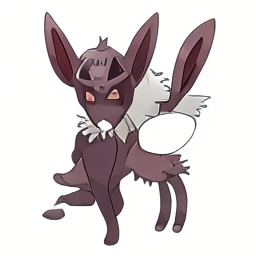

In [8]:
display.HTML(f'<img src="{get_image()}">')

### Random image of specific energy type


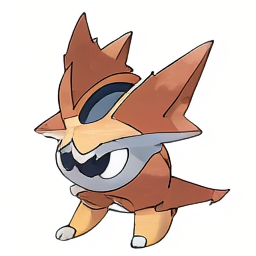

In [9]:
display.HTML(f'<img src="{get_image("fire")}">')

### Specific image


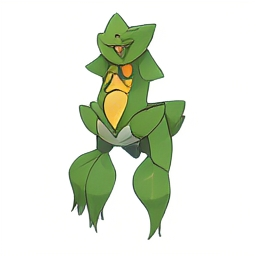

In [10]:
display.HTML(f'<img src="{get_image("grass", 376)}">')